<a href="https://colab.research.google.com/github/tuanaasuokturk/MBC_data_analysis/blob/main/Assignment_5_ipynb_Tuana_Asu_Okturk_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size: 2.5em; font-weight: bold; margin-top: 0.5em; margin-bottom: 0.5em;">
Assignment 5: Statistical inference, bootstrap and model comparison</h1>

**In this assignment, we will see how to compute confidence intervals using bootstrapping and how to compare which model is best supported by an experimental dataset.**

- Learn how to use bootstrapping to generate new sample datasets
- Estimate our model parameter on these new sample datasets
- Quantify the uncertainty about our parameter estimate using confidence intervals

- Compare which statistical model better explains an experimental dataset using penalized log-likelihood metrics (AIC, BIC)

- Alternatively, compare different models by splitting the data into one part used to estimate model parameters and one part to test the estimated model (testing on held out data), and generalizing this approach using cross-validation

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b>

The following resources will help you to get ready to complete this assignment. <br>
Watch <a href="https://youtu.be/9JfXKmVB6qc?t=910" target="_blank">the second part of this video</a> to have a quick overview of how to assess model fits. Remember that all types of regression analysis and statistical test can be seen as testing how well a generative model (i.e. a linear model with noise) can explain your data. Then watch these series of short videos on more specific topics (all these videos are taken from the <a href="https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/chapter_title.html" target="_blank">tutorials of the Model Fitting day at Neuromatch Academy</a>):
        <li><a href="https://youtu.be/hs6bVGQNSIs" target="_blank">this video</a> on bootstrapping the estimate the confidence intervals for your model parameters. If that felt too dense, go to the wonderful Statquest videos on bootstrapping for a down-paced presentation (<a href="https://www.youtube.com/watch?v=Xz0x-8-cgaQ" target="_blank">part 1</a> and <a href="https://www.youtube.com/watch?v=N4ZQQqyIf6k" target="_blank">part 2</a>)</li>
        <li> <a href="https://youtu.be/NcUH_seBcVw" target="_blank">this video</a> on the bias-variance trade-off, which provides the conceptual basis for model selection, i.e. finding a model that fits the data well while keeping model complexity as low as possible. For statistical analysis, this is equivalent to look for the significant effects as components that we must include in the model in order to capture the structure of the data.</li>
        <li> <a href="https://youtu.be/OtKw0rSRxo4" target="_blank">this video</a> about how to perform model comparison in practice by testing the model on a test set (i.e. a part of the dataset that was not used for estimating the parameters), and how this is generalized in <b>cross-validation</b></li>

---
# Setup

We will keep working on the same example as in Assignments 3 and 4 (psychometric curves and logistic regression).

We start by importing the typical libraries, importing the data as a dataframe and adding the relevant columns.

In [ ]:
#1. Load the packages that we will need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm


# 2. load the data
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC_data_analysis/main/A3_PsychometricCurves/Experiment1_all_subjects.csv",sep=',')

# 3. Define a function that takes two angles as input and outputs the angular distance between the two
def circ_dist(angles1,angles2): #define the name and set the arguments between parentheses
    angle_diff = angles2 - angles1 # simple difference
    angle_diff_rad = angle_diff*np.pi/180 # convert to radians
    angular_dist_rad = np.angle( np.exp(1j*(angle_diff_rad))) ## mathematical operation to get the circular distance (in radians)
    angular_dist = 180/np.pi*angular_dist_rad ## convert back to degrees
    output = np.round(angular_dist) # round value to eliminate numerical imprecisions (all values are integer)
    return output #return the circular distance in degrees

# 4. Compute the displacement of the probe from the target and add it as a new column to the dataframe:
df['displacement'] = circ_dist( df['target'], df['probe'] );

# 5. change the column 'response': all -1's become 1's and 1s become 0's
df.response *= -1 # multiply by -1, so now 1 codes for CCW and -1 for CW
df.loc[df.response==-1, 'response'] = 0 # convert -1s to 0s, so now 1 codes for CCW and 0 for CW

df.head()

,subject,load,delay,target,probe,near,response,displacement
0,1,3,0.1,24,18,10,1,-6.0
1,1,3,0.1,307,311,296,1,4.0
2,1,3,0.1,151,147,289,0,-4.0
3,1,4,0.1,326,334,32,1,8.0
4,1,3,0.1,73,77,60,1,4.0


**Helper functions**

There is nothing really new here as these functions were already used in Assignments 3 and 4. They are here to make your life easier. Have a look at what they are doing and use them in your code below.

In [ ]:
def logistic(x):
    """
    Returns the output of the logistic function for the given input value (float or array-like).
    """
    y = 1 / (1 + np.exp(-x))
    return y

def psychometric_model(d, w0, w1):
    """
    Compute the psychometric function based on a simple logistic model.
    Args:
       d (ndarray): input values.
       w0 (float): intercept for logistic regression.
       w1 (float): slope for logistic regression.
    Returns:
       ndarray: The `y` data points of the psychometric function.
          In our case, this corresponds to the probability of CCW responses.
    """
    p = logistic(w0 + w1*d)
    return p

def plotcurve(df, color):
    """
    Plot the fitted psychometric curve with experimental datapoints on top.
    Args:
       df (dataframe): experimental data
       color (string): color of the datapoints and fitted line
    """

    mod = smf.glm(formula='response ~ displacement', data=df, family=sm.families.Binomial())
    res = mod.fit()

    myx = np.linspace(-20,20,100)
    yfit=res.predict(pd.DataFrame({'displacement': myx}))

    # plot the psychometric function (fit)
    plt.plot(myx,yfit,'-', color=color,label='fit')

    # plot the psychometric curve (datapoints)
    df.groupby('displacement').response.agg(('mean','sem')).plot(yerr='sem', color=color, fmt = 'o', ax=plt.gca(), label='data');


**Show psychometric curve for subject 1**

Your first task is to use the provided function `plotcurve` to plot the psychometric curve of subject 1.
- Select the data of subject number 1
- Use the pre-defined functions from above to plot the psychometric curve (datapoints and fit).

*For parts 1 and 2 of this assignment, we will work with the data of this subject.*

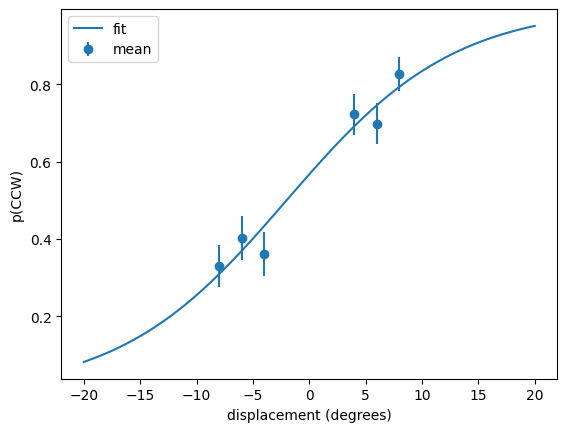

In [ ]:
# select subject 1
ds = df[df['subject'] == 1]

# plot the psychometric curve
fig, ax = plt.subplots()
plotcurve(ds, 'C0')
ax.set(xlabel='displacement (degrees)', ylabel='p(CCW)');
ax.legend();

---
# Bootstrapping

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated parameters from a given model, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). We will apply it here for a logistic regression model but it really **can be used for model parameters from any statistical model**, or even **for any metric of a dataset**. For example, boostrapping is the method of choice to estimate confidence interval for the median value of a dataset. Boostrapping consists in :
1. generating many new synthetic datasets from the initial true dataset by randomly sampling from it
2. then, estimating the model parameters for each one of these new datasets
3. finally, looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. the same data point can appear multiple times in a resampled dataset. Also note that in practice we need a lot of resampled datasets to get robust distribution of the parameters, here we use 2000.

To explore this idea, we will work with the data from subject 1 and consider a simple logistic regression model for predicting the subject's responses from the angular displacement of the target and probe.

## Resample Dataset with Replacement

In this exercise you will implement a method to resample a dataset with replacement. The method accepts $\mathbf{x}$ and $\mathbf{y}$ arrays. It should return a new set of $\mathbf{x}'$ and $\mathbf{y}'$ arrays that are created by randomly sampling from the originals.

We will then compare the slope and intercept estimated in the original dataset and in the resampled dataset to get a feeling of how resampling affects these estimates.

**Hint:** The [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method will be useful here. Before you start to implement the resampling function, first make sure that you understand the following two lines of code.

In [ ]:
print(np.random.choice(10, size=10, replace=False))
print(np.random.choice(10, size=10, replace=True))

[6 4 8 5 9 1 2 3 7 0]
[6 7 2 1 4 2 0 4 8 6]


Both lines generate a random sequence of the numbers 1-10.
In the case *without* replacement (top), this gives a permutation of the numbers, i.e. each number appears once and only once.
If we sample *with* replacement (bottom), some of the numbers may be repeated, some may be absent.

Bootstrapping relies on sampling with replacement.

**Complete the following function which we will use to generate the bootstrap samples.** The function takes the values of the regressors `x` and dependent variable `y` from the original dataset, and outputs new variables where the data points (e.g. trials) have been sample with replacement.

In [ ]:
def resample_with_replacement(x, y):
    """Resample data points with replacement from the dataset of `x` inputs and
    `y` measurements.
    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
    measurement values to the inputs.
    Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
    """

    # number of datapoints
    nData = len(x)

    # Get array of indices for resampled points
    sample_idx = np.random.choice(nData, size=nData, replace=True)

    # Sample from x and y according to sample_idx
    x_ = x[sample_idx]
    y_ = y[sample_idx]

    return x_, y_

**Generate resampled data and display the psychometric curves for the original and the resampled data.**

Repeat this several times to get a feeling for the "randomness", that is how different the resampled data is from the original data.
Note that `values` (in the first line) returns the numerical data contained in the dataframe (a numpy array).

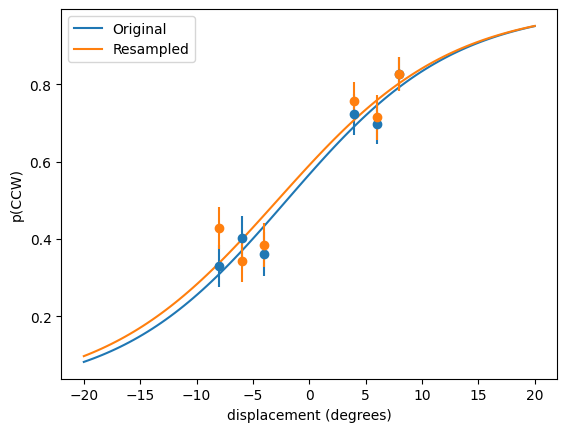

In [ ]:
# resample the data
x_, y_ = resample_with_replacement(ds.displacement.values, ds.response.values)

# place the resampled data in a dataframe
ds_resampled = pd.DataFrame({'displacement': x_, 'response': y_})


# plot the psychometric curve
fig, ax = plt.subplots()
plotcurve(ds, 'C0')
plotcurve(ds_resampled, 'C1')
ax.set(xlabel='displacement (degrees)', ylabel='p(CCW)');
plt.legend(('Original','Resampled'));

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

## Bootstrap Estimates

In this exercise you will implement a method to run the bootstrap process of generating a set of logistic regression weights $w_0$ and $w_1$ from resampled datasets of inputs ($\mathbf{x}$, the angle between target and probe) and  measurements ($\mathbf{y}$, the subject's responses). You should use `resample_with_replacement` here.

We will then use this function to look at the $w_0$ and $w_1$ values obtained from different samples.

First **complete the following function that runs a simple logistic regression as in Assignment 4**.
Just as a reminder, we consider the influence onto our binary variable (choices) of a single variable: the displacement of the probe w.r.t the target stimulus (the parameter that controls the difficulty of the trial).
Defining this function is useful because the only result that we want to store for the 2000 bootstrap samples are the values of the regression weights $w_0$ and $w_1$. Also, defining the function will make our later code easier to read.


In [ ]:
# @markdown Execute this cell for helper function `solve_log_regression`
def solve_log_regression(df):
    """Solve the logistic regression

    Args:
    df:dataframe

  Returns:
    float: w0, w1 estimated from logistic regression model fitted to data in df
    """

    # declare the logistic regression model
    mod = smf.glm(formula='response ~ displacement', data=df, family=sm.families.Binomial())

    # fit the model
    res = mod.fit()

    return res.params['Intercept'], res.params['displacement']

**Use your function to estimate the regression weights for the original data and the resampled data from above** (just to see if everything works correctly.

In [ ]:
w0, w1 = solve_log_regression(ds)
print("original data:")
print("w_0 = ", w0,"w_1 = ", w1)
w0_resampled, w1_resampled = solve_log_regression(ds_resampled)
print("resampled data:")
print("w_0 = ", w0_resampled,"w_1 = ", w1_resampled)

original data:
w_0 =  0.2690967358301605 w_1 =  0.13434999041289825
resampled data:
w_0 =  0.36680070033570217 w_1 =  0.13002264381374565


**We are now ready to implement the bootstrap function**

In [ ]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute
  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros((n,2))

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)
    df_resampled = pd.DataFrame({'displacement': x_, 'response': y_})
    w0, w1 = solve_log_regression(df_resampled)

    # Compute theta_hat for this sample
    theta_hats[i,:] = solve_log_regression(df_resampled)

  return theta_hats

# For testing purposes we set the random seed so that we always get the same result
np.random.seed(123)

# Get bootstrap estimates (generate only 3 bootstrap samples for a quick check if everything works)
theta_hats = bootstrap_estimates(ds.displacement.values, ds.response.values, n=3)

# Now we initialize the random number generator so that we get different random numbers from now on.
np.random.seed()

print(theta_hats)


[[0.34574091 0.12517866]
 [0.25904594 0.11718731]
 [0.05620029 0.14365177]]


You should see `[[0.34574091 0.12517866] [0.25904594 0.11718731] [0.05620029 0.14365177]]` as the first three estimates.

Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are. Note that now we want to generate 2.000 bootstrap samples and fitting the corresponding logistic regression models can take a few seconds (depending on your machine).

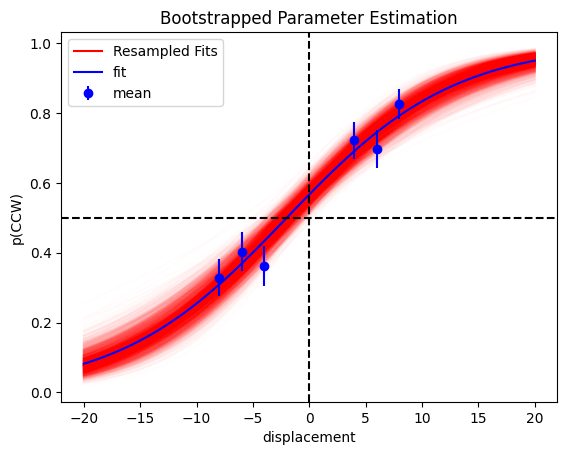

In [ ]:
# number of bootstraps
nBootstrap = 2000

# regressor and dependent variables from the original dataset
x = ds.displacement.values
y = ds.response.values

# compute bootstrap parameters (both slope and intercept)
theta_hats = bootstrap_estimates(x, y, n=nBootstrap)

# create plot
fig, ax = plt.subplots()

# plot fitted psychometric curves for all resampled datasets
myx = np.linspace(-20, 20, 100)
for i in range(nBootstrap):
    # estimated parameters for corresponding resampled dataset
    theta_hat = theta_hats[i, :]

    # compute predicted probability of CCW response according to that model
    y_hat = psychometric_model(myx, theta_hat[0], theta_hat[1])

    # plot the psychometric curve in light red
    ax.plot(myx, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i == 0 else '')

# Plot psychometric curve for the original dataset (blue)
plotcurve(ds, color='blue')

plt.title('Bootstrapped Parameter Estimation')
plt.xlabel('displacement')
plt.ylabel('p(CCW)')

# Change alpha property of legend line
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)
ax.legend()

# add vertical and horizontal reference lines
plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0.5, color='k', linestyle='--')

plt.show()

This looks pretty good! The bootstrapped estimates spread around the observed datapoints, as we would have hoped.  As always it is a good idea to visually inspect the quality of estimates.
Now you can try to **run the bootstrap procedure on all the subjects together** (just taking all the data, ignoring the subject identity). **What happens to the spread of the bootstrap estimates?**

When you run the bootstrap procedure across all subjects together, essentially pooling the data without accounting for individual differences, the spread of the bootstrap estimates typically shrinks. This happens because, by aggregating data from all subjects, you're effectively increasing the sample size. In statistical terms, the variability of the bootstrap estimates tends to decrease as the sample size increases—this is in line with the general statistical principle that the precision of parameter estimates improves with more data. As a result, the confidence intervals around your model parameters (such as the slope and intercept) tend to tighten, and the spread of the bootstrap fits becomes smaller.
However, this general trend can change depending on the nature of the subjects' data. If the subjects have similar characteristics and their individual data points follow similar patterns, the result of pooling the data will simply lead to a more precise estimate. The variability between the subjects will have less of an impact, and the bootstrap procedure will likely yield tighter, more consistent parameter estimates.
On the other hand, if the subjects differ significantly—if, for example, each subject has a different threshold for the task you're measuring—then pooling all the data together can mask these individual differences. In this case, the bootstrap estimates may not shrink as expected. Instead, you might see a more variable or even multi-modal distribution of the estimates. The spread of the bootstrap estimates could remain large, or it could even appear more spread out than when you only consider individual subjects. This is because the variability between subjects now dominates the tighter estimates you would have gotten if you had only considered one subject at a time. Essentially, pooling in this case dilutes the model’s ability to capture the distinct characteristics of each subject’s performance.
So, whether the spread shrinks or remains the same largely depends on how similar the subjects are in terms of the measured parameters. If there’s significant between-subject variability, pooling the data can introduce more uncertainty into the estimates, as the combined data might not fit any individual subject's model very well.

---
# Confidence Intervals

Let us now quantify how uncertain our estimated parameters ($w_0$ and $w_1$) is. We do so by computing [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (CIs) from our bootstrapped estimates. The most direct approach is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

##  Plot bootstrap samples and confidence intervals


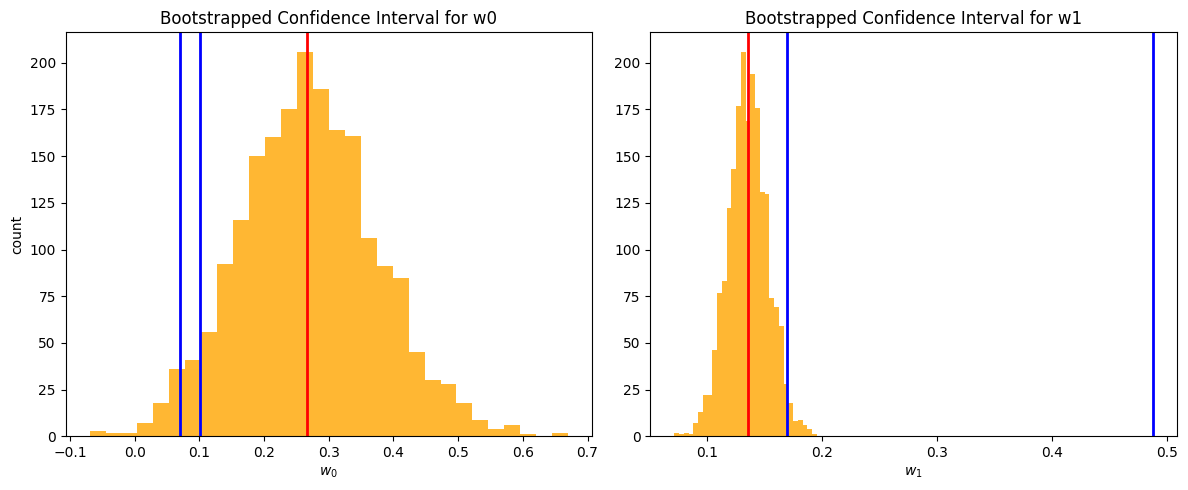

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# to run the analysis for all subjects, uncomment the following 3 lines
#x = df.displacement.values
#y = df.response.values
#theta_hats = bootstrap_estimates(x, y, n=2000)

means   = np.mean(theta_hats, axis=0)            # mean w0 and w1 over all bootstraps
stds    = np.std(theta_hats, axis=0)             # standard deviation of w0 and w1 over all bootstraps
medians = np.median(theta_hats, axis=0)          # median w0 and w1 over all bootstraps
CIs     = np.percentile(theta_hats, [2.5, 97.5], axis=0).T  # 95% CI for w0 and w1 from bootstraps (low, high)
medians = np.median(theta_hats, axis=0)                           # shape (2,)
cis_lo = np.percentile(theta_hats, 2.5, axis=0)                   # shape (2,)
cis_hi = np.percentile(theta_hats, 97.5, axis=0)                  # shape (2,)

# insert below your code that displays two histograms (one for the bootstrap samples of $w_0$
# and one for the bootstrap samples of $w_1$)
# display vertical lines to indicate the median and confidence intervals over each parameter

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
titles = ['Bootstrapped Confidence Interval for w0',
          'Bootstrapped Confidence Interval for w1']
xlabels = [r'$w_0$', r'$w_1$']

for i in range(2):
    ax[i].hist(theta_hats[:, i], bins=30, color='orange', alpha=0.8)
    ax[i].axvline(medians[i], color='red', lw=2, label='Median' if i == 0 else '')
    ax[i].axvline(CIs[0, i], color='blue', lw=2, label='95% CI' if i == 0 else '')
    ax[i].axvline(CIs[1, i], color='blue', lw=2)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(xlabels[i])
    if i == 0:
        ax[i].set_ylabel('count')

plt.tight_layout()
plt.show()

**Are the responses of this subjects biased?** (Hint: the bias is reflected in $\hat{w_0}$).

The subject’s responses likely exhibit bias, as indicated by the skewed distributions of the bootstrapped estimates for w0.

It's a good idea to **repeat the analysis with a different subject or with all subjects pooled together** in order to get a better intuition about the datapoints, fitted psychometric curve and confidence intervals for the fitted parameters.

## Comparison with parametric confidence intervals


Finally, **compare the confidence intervals obtained using bootstrap with the confidence intervals reported by `sm.glm`**.
Also compare the standard deviation of the bootstrapped parameter estimates to the std err reported by `sm.glm`. These latter are computed using a parametric method known as the Laplace approximation, that assumes that the true value of the parameter follows a normal distribution centered on the maximum-likelihood estimate. This approximation works well for large datasets (thousands of observations or more) but not so well for small to medium datasets, which is why the bootstrap method should be preferred then.

Note that the code below uses [f-Strings](https://realpython.com/python-f-strings/#f-strings-a-new-and-improved-way-to-format-strings-in-python), a convinient way of displaying numbers with a certain format (e.g. number of digits after the comma).

In [ ]:
print(f"                   mean      std        [0.025      0.975]")
print(f"----------------------------------------------------------")
print(f"w0               {means[0]:.4f}      {stds[0]:.3f}       {CIs[0,0]:.3f}       {CIs[1,0]:.3f}")
print(f"w1               {means[1]:.4f}      {stds[1]:.3f}       {CIs[0,1]:.3f}       {CIs[1,1]:.3f}")
print(f"==========================================================")

                   mean      std        [0.025      0.975]
----------------------------------------------------------
w0               0.2697      0.105       0.069       0.101
w1               0.1356      0.017       0.488       0.170


In [ ]:
# declare the logistic regression model
mod = smf.glm(formula= 'response ~ displacement' , data = ds, family = sm.families.Binomial() )

# fit the model
res = mod.fit()

# print results as a summary table
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                  448
Model:                            GLM   Df Residuals:                      446
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -272.77
Date:                Sat, 08 Nov 2025   Deviance:                       545.54
Time:                        09:18:00   Pearson chi2:                     447.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1445
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2691      0.104      2.593   

Bootstrap:

CIs are directly derived from the empirical distribution, which can capture asymmetries or skewness.

More appropriate when you expect non-normal distributions of parameters or when sample sizes are not large.

GLM:

CIs are based on a parametric assumption (normal distribution), which works well for large datasets where the sampling distribution of the estimator is approximately normal.

For small datasets or complex parameter distributions, bootstrap is preferable as it makes fewer assumptions about the underlying data.

In this case, the GLM confidence intervals seem narrower and symmetric, whereas the bootstrap intervals better capture the potential asymmetry or skewness of the estimates, especially for
𝑤
0
w
0. This indicates that bootstrap methods should be favored for smaller, more heterogeneous datasets where the assumption of normality may not hold.

---
## Summary of bootstrapping

- Bootstrapping is a **resampling procedure** that allows to **build confidence intervals around inferred parameter values**
- it is a **widely applicable** and very practical method that relies on computational power and pseudo-random number generators (as opposed to more classical approaches than depend on analytical derivations)
- it is **non-parametric**: the confidence intervals provided by statistical libraries are not always accurate because they assume an underlying gaussian distribution for parameters, which is not always the case.

# Model comparison using penalized likelihood
In traditional statistics, we test the presence of an effect in the data by assessing if the absence of the effect is credible, i.e. whether the null hypothesis (the absence of the effect) can be rejected. This is what we have done above, we tested whether a null value for the intercept is plausible. But the validity of the alternative hypothesis (that the intercept is non-null) is never tested directly.

Now, using the framework of statistical modelling offers a richer set of tools because we can **directly compare the null hypothesis and the alternative hypothesis** and assess which one better accounts for the experimental data. The approach is even more generic: the tools of statistical modelling / machine learning allow to directly compare any set of statistical models based on how each of these model explains a given dataset.

In previous assignments, we have seen two metrics that assess how well a model captures the data:
- the mean-squared error (MSE), in the case of linear regression (the smaller the better)
- the (log-)likelihood, which can be used in all settings (the larger the better). Remember that the maximum-likelihood approach is actually equivalent to the minimum-squared error for linear regression, but works in other cases.

We have used these two metrics to decide, given a certain parametric model of the data (i.e. linear regression), which set of parameters better describe the data. But the same philosophy can be used to decide which of two different models better describes the data: **the larger the likelihood, the better the model**.

Yet there is a caveat. The likelihood is usually estimated for each model at the maximum-likelihood parameters. But if a certain model has more parameters, then space of parameters is larger: the model is more flexible (it has more *degrees of freedom*), so it will receive an unfair advantage when comparing the likelihoods with other models. Even if those extra parameters do not contribute anything to capturing the true processes that underlie the generation of the data, giving this extra-flexibility can allow it to improve the likelihood simply by adjusting to noise. This is the problem of **overfitting**. In the videos, we have seen that we need to find a right balance between fitting the data and model parsimony, what is known as the **bias-variance trade-off**.

To make the comparison more fair between models of different complexities, one approach is simply to apply a certain penalty term on top of the likelihood that penalizes the models with more parameters. The two most popular metrics for doing so just differ in the strength of the penalty term:
- the **Akaike Information Criterion (AIC)** is computed as $AIC = 2k - 2 \hat{LLH}$, where $k$ is the number of parameters of the model (i.e. a simple linear regression model will have two, the intercept and the slope) and $\hat{LLH}$ is the log-likelihood of the model estimated at the maximum-likelihood parameters (the value that is provided in the summary of the model after fitting).
- the **Bayesian Information Criterion (BIC)** is computed as $BIC = k \log n - 2 \hat{LLH}$ where $n$ is the number of observations (i.e. trials).

The smaller the AIC (or BIC), the better is the model, because of the negative sign before the log-likelihood. The first part of the equation is positive and corresponds to the penalty term. That term is larger in the case of the BIC, i.e. the BIC penalizes more severely models with many parameters than the AIC. In other words, it will be more conservative in rejecting the null hypothesis. It's important to note that these are **relative measures**: their raw values tell us very little, it's only by comparing values between different models that we can interpret which model better captures the data. So we cannot conclude from the BIC/AIC that one model is a good model of the data; only that it is a better model of the data than others.

Akaike's rule of thumb: **two models are essentially indistinguishable if the difference of their AICs is less than 2** (same for BIC). The larger the difference, the more evidence towards the better model against the other.

But enough talking, let's see how to apply this in practice. We will look back to the analysis that suggests that, in memory trials, the relative position of the distractor impacts the choice of the participants.

First, fit a **logistic regression model with probe displacement and distance of the distractor as regressors, restricting the analysis to memory trials** (i.e. delay of 1s or 3s).
Unlike what we did in the previous assignment where we analyzed data from all subjects together without taking into account the population heterogeneity, the good practice is to apply statisical modelling on a single-subject data (or used mixed-effects models). Here we will **work on on the data for one subject only: subject 5**.

In [ ]:
# Compute the distance between the distractor and the target and add as a new column to the dataframe:
df['dist_distractor'] = circ_dist(df['target'], df['near'])

# we restrict the dataframe to memory trials and trials from subject 5
memory_trials_subject5 = df[(df['delay'] == 1) | (df['delay'] == 3)]

# dataframe for memory trials and subject 5
df_memory = memory_trials_subject5[memory_trials_subject5['subject'] == 5]

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset.
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_memory = df_memory.reset_index(drop=True)

# declare the logistic regression model (with displacement and distractor)
mod = smf.glm(formula='response ~ displacement + dist_distractor',
              data=df_memory,
              family=sm.families.Binomial())

# fit the model
res = mod.fit()

# print results as a summary table
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                  291
Model:                            GLM   Df Residuals:                      288
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -163.07
Date:                Sat, 08 Nov 2025   Deviance:                       326.15
Time:                        09:18:45   Pearson chi2:                     293.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2312
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1305      0.135     

We will want to compare this model to the null model, which is exactly the same but where the influence of the distractor is removed. **Fit the null model**.

In [ ]:
# declare the null logistic regression model (no distractor)
mod_null = smf.glm(formula='response ~ displacement', data=df_memory, family=sm.families.Binomial())

# fit the null model
res_null = mod_null.fit()

# print results of the null model as a summary table
print(res_null.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               response   No. Observations:                  291
Model:                            GLM   Df Residuals:                      289
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -167.57
Date:                Sat, 08 Nov 2025   Deviance:                       335.13
Time:                        09:18:50   Pearson chi2:                     292.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2070
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1366      0.133      1.025   

Let us first **compare the log-likelihood of both models**. This value (provided in the summary) is given by `res.llf`.

In [ ]:
print("LLH for the model with distractor: ", res.llf)
print("LLH for the null model: ", res_null.llf)

LLH for the model with distractor:  -163.0726671664243
LLH for the null model:  -167.56677836222292


**What do you observe? Is it expected?**

Interpretation:

The log-likelihood measures how well the model fits the data. A higher log-likelihood (closer to 0, or less negative) indicates a better fit.

In this case, the model with the distractor has a higher log-likelihood, suggesting that including the distractor improves the model fit compared to the null model, which only considers displacement as a predictor.

The difference in log-likelihoods can be used to assess the model's improvement when adding the distractor, and a likelihood ratio test can formally quantify this improvement.

(Optional) The value of the AIC is directly provided by `statsmodel` as `res.aic`.
**Check that the value corresponds to the formula provided above** (the list of parameters of the model is given by `res.params`).

In [ ]:
# AIC
print("Statsmodel-defined AIC:" + str(res.aic))

# Use the formula
nParam = len(res.params)
AIC = 2 * nParam - 2 * res.llf
print("AIC: ", AIC)

Statsmodel-defined AIC:332.1453343328486
AIC:  332.1453343328486


Now **compare the AIC from the two models**.

In [ ]:
# AIC comparison

aic_distractor = res.aic          # model: response ~ dist_distractor
aic_null       = res_null.aic     # null model: response ~ displacement

print("AIC for the model with distractor: ", aic_distractor)
print("AIC for the null model:          ", aic_null)

# (optional) AIC difference
delta_aic = aic_null - aic_distractor
print("ΔAIC (null - distractor):        ", delta_aic)

AIC for the model with distractor:  332.1453343328486
AIC for the null model:           339.13355672444584
ΔAIC (null - distractor):         6.988222391597219


**Interpret the results.**

For subject 5’s memory trials, responses are not explained by target displacement alone. The distance between target and distractor reliably predicts responses, so the distractor has a meaningful effect on behavior.

**Compare the BIC from the two models** (use  `res.bic_llf`, not `res.bic`).

In [ ]:
# Re-fit both models (so this cell works even after a restart)

# full model: displacement + dist_distractor
mod_full = smf.glm(
    formula='response ~ displacement + dist_distractor',
    data=df_memory,
    family=sm.families.Binomial()
)
res_full = mod_full.fit()

# null model: only displacement
mod_null = smf.glm(
    formula='response ~ displacement',
    data=df_memory,
    family=sm.families.Binomial()
)
res_null = mod_null.fit()

# BIC comparison using bic_llf
bic_full = res_full.bic_llf
bic_null = res_null.bic_llf

print("BIC for the model with distractor: ", bic_full)
print("BIC for the null model:           ", bic_null)

delta_bic = bic_null - bic_full
print("ΔBIC (null - distractor):         ", delta_bic)


BIC for the model with distractor:  343.1653041343631
BIC for the null model:            346.48020325878883
ΔBIC (null - distractor):          3.3148991244257218


**Interpret the results.**

Lower BIC is better, and BIC penalizes extra parameters more strongly than AIC.

Here, the model including dist_distractor still has the lower BIC, so it is preferred, but the evidence is moderate rather than huge:

A ΔBIC between 2 and 6 is usually read as positive but not decisive support for the lower-BIC model.

So, also under this stricter criterion, adding the distractor distance improves the model enough to justify its inclusion: for subject 5’s memory trials, distractor distance carries additional information about responses beyond displacement alone.

# Testing model performance on held out data
## Training set, test set

The AIC and BIC are convenient because they are easy to compute, but they are just "approximately good". For large sample size, they work well, but for smaller sample size they may not accurately describe which model is better. Moreover, as we have seen, they sometimes provide contradictory results, which is always frustrating.

Another approach for comparing models on experimental data while adjusting for model complexity is to test the model performance on datapoints that have not been used to train/fit the model (i.e. to estimate the maximum-likelihood parameters). If a model with many parameters is overfitting, i.e. its parameters are adjusted to predict very well the datapoints it was trained on (it is fitting 'noise'), then its performance may decrease severely when testing the model with the same parameters but on a new dataset.
How this is done in practice is that we **split our datasets into two smaller datasets**: one **training set** which is used to fit the model and extract the maximum-likelihood parameters, and one **test set** (or held-out data) which is used to evaluate the performance of the model previously fitted. This method naturally corrects for model complexity when comparing different models. Let us do this.

The first step is to **split our dataset in two**. In general the training set is the larger, usually taking 80% of the data, while the test set takes the remaining 20%.
This can be done using `train_test_split` from `statsmodel`, which randomly assign each observation to either the train or test set, while controlling for the relative size of each set.

In [ ]:
# import train_test_split
from sklearn.model_selection import train_test_split

# make sure to use again data for subject 5!

# we restrict the dataframe to memory trials and trials from subject 5
memory_trials_subject5 =  df[(df['subject'] == 5) & ((df['delay'] == 1) | (df['delay'] == 3))]

# dataframe for memory trials and subject 5
df_memory = memory_trials_subject5

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset.
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_memory = df_memory.reset_index(drop=True)

# create two dataframes. Parameter test_size (between 0 and 1) controls the relative size of the test set.
df_train, df_test = train_test_split(df_memory, test_size=0.2, random_state=123)

# when we take a subset of a dataframe, the indices reflect the position of the selected rows in the old dataset.
# We use reset_index to reset the indices, i.e. going back as 1, 2, ... (this avoids frequent error afterwards)
df_test = df_test.reset_index(drop=True)

**Check the size (number of rows) of the train and test sets. Check how this is affected by changing the `test_size` parameter.**

In [ ]:
print("Number of training datapoints: ", df_train.shape[0])
print("Number of test datapoints: ", df_test.shape[0])

Number of training datapoints:  232
Number of test datapoints:  59


If you were to sample the data "manually" to split between the train and test sets (instead of using `train_test_split`), would you set the `replace` option of `np.random.choice` to `True` or `False`?

If you split manually with np.random.choice, you should use replace=False, because each trial must go either into train or into test, not both.

Now, let's follow the procedure:
- **fit both models (with or without distractor regressor) to the train set**
- **use the fitted models to generate predictions for the probability of CCW response on the test set**. (Remember we in Assignment 4 we saw how to use `res.predict`)

In [ ]:
# fit model with impact of distractor on training set
mod_full = smf.glm(
    formula='response ~ displacement + dist_distractor',
    data=df_train,
    family=sm.families.Binomial()
)
res_full = mod_full.fit()

# fit null model on training set
mod_null = smf.glm(
    formula='response ~ displacement',
    data=df_train,
    family=sm.families.Binomial()
)
res_null = mod_null.fit()

# use the fitted statistical model to compute p(CCW) for each value in this dataframe
df_test['pCCW_full'] = res_full.predict(df_test)   # model with distractor
df_test['pCCW_null'] = res_null.predict(df_test)   # null model

We now have a prediction for each trial in the test set, and what we want is a single metric, the LogLikelihood on the test data, to compare the models. There are no built-in method in `statsmodel` for computing the log-likelihood on test data, so we use the following function:

In [ ]:
# compute likelihood of test data
def loglikelihood_binary(pModel, resp):
    # number of observations / trials
    n = len(pModel)

    # initialize log-likelihood
    LLH = 0

    # loop through trials
    for i in range(n):

        if (resp.iloc[i]==1):
            lh = pModel.iloc[i]
        else:
            lh = 1-pModel.iloc[i]

        # add logarithm of likelihood for the trial to LLH
        LLH += np.log(lh)

    return LLH

Use the function above to **compute the log-likelihood of both models on the test data**.

In [ ]:
LLH_test      = loglikelihood_binary(df_test['pCCW_full'], df_test['response'])
LLH_test_null = loglikelihood_binary(df_test['pCCW_null'], df_test['response'])

print("Log-likelihood of full model on test data",LLH_test)
print("Log-likelihood of null model on test data",LLH_test_null)

Log-likelihood of full model on test data -36.32277948367416
Log-likelihood of null model on test data -37.80454570170721


**Interpret the results.**

On the held-out test trials, the model that includes the distractor term predicts participants’ choices slightly better than the simpler model.

The full model (with displacement + dist_distractor) has a log-likelihood of −36.32, whereas the null model (with only displacement) has −37.80. Because log-likelihood is better when it is less negative, this means the test data are more compatible with the predictions of the full model. The difference (about 1.5 log-units) is not huge, but it is meaningful: expressed as a likelihood ratio, the observed test responses are roughly 4 times more likely under the model that takes distractor distance into account than under the model that ignores it.

Together with the AIC and BIC results, this tells a coherent story: for subject 5’s memory trials, adding the distractor–target distance improves predictive performance without obvious overfitting. The distractor has a real, but modest, influence on the probability of a CCW response.

## From validation to cross-validation


That is good, but if you run the analysis again, you will notice that the results vary every time. This is because everytime you run the analysis, you generate a new random split of the dataset between the train and test sets. Obviously, our measure of which model is best should not depend on a random generator! One way of dealing with this is to perform various splitting, compute the test score for each split, and then average over splittings. The more splittings we perform, the more robust our measure will be. This is usually done using **cross-validation**, where the dataset is chunked in pieces (or folds), and each piece alternatively takes the role of the test set. The most standard form of cross-validation is K-fold cross-validation, where K describes the number of folds in which the data is split. This is illustrated below using $K=5$. The log-likelihood of cross-validated data is described as "Cross-Validated Log-Likelihood" (**CVLL**).

(Image taken from [https://docs.ultralytics.com/es/guides/kfold-cross-validation/])

![Task](https://user-images.githubusercontent.com/26833433/258589390-8d815058-ece8-48b9-a94e-0e1ab53ea0f6.png)

In general, the larger is K, the more robust your measure is. The extreme case is **leave-one-out cross-validation** (LOOCV) where basically you split the datasets in sets of just one observation (trials); then on each fold you fit all your dataset on all the dataset but one observation and test it on this single heldout observation. So LOOCV is like K-fold CV where K equals the number of observations. However, by increasing K, you also increase the computational complexity as you need to fit the model over and over, so things can get slow.

Cross-validation is a robust method for choosing the best statistical model for a certain dataset. It does not suffer the same limitations as AIC/BIC, and can be used for other metrics than the log-likelihood such as the mean squared error or the classification accuracy. It can be used also for complex methods when the likelihood cannot be evaluated.
This is why **cross-validation is the standard method in machine learning** to compare the performance of any type of models (deep networks, auto-encoders, SVMs, etc.).

In this code, we split the data into 10 subsets using `Kfold` (from `sklearn.model_selection`) - $K=10$ is the minimum value to ensure robust performance. `KFold` handles cross-validation subset splitting training and test assignments.  In particular, the `Kfold.split` method returns an iterator which we can loop through. On each loop, this iterator assigns a different subset as validation and returns new training and validation indices with which to split the data.

We will loop through the 10 train/validation splits and on each split compute the log-likelihood of both models on the test set. Then we will average the CVLL over splits.

In [ ]:
#import KFold
from sklearn.model_selection import KFold

# number of folds
K = 10

#create Kfold object
kf = KFold(n_splits = K, shuffle=True)

**Apply K-fold validation on the dataset to compute the CVLL on both the distractor and null models.**

In [ ]:
# Initialize CVLL as numpy array with K rows and 2 columns, one for each model
CVLL_all = np.zeros((K, 2))

# loop through all folds (the complex syntax provides the loop counter i, as well as the indices of trials in train and test sets for the corresponding fold)
for i, (train_index, test_index) in enumerate(kf.split(df_memory)):

    # dataframe with training data
    df_train = df_memory.iloc[train_index].reset_index(drop=True)

    # dataframe with test data
    df_test = df_memory.iloc[test_index].reset_index(drop=True)

    # fit model with impact of distractor on training set
    mod_full = smf.glm(
        formula='response ~ displacement + dist_distractor',
        data=df_train,
        family=sm.families.Binomial()
    )
    res_full = mod_full.fit()

    # fit null model on training set
    mod_null = smf.glm(
        formula='response ~ displacement',
        data=df_train,
        family=sm.families.Binomial()
    )
    res_null = mod_null.fit()

    # use the fitted statistical models to compute p(CCW) for each value in this dataframe
    p_full = res_full.predict(df_test)
    p_null = res_null.predict(df_test)

    # compute the CVLL for each model
    LLH_test      = loglikelihood_binary(p_full, df_test['response'])
    LLH_test_null = loglikelihood_binary(p_null, df_test['response'])

    # add as row in array
    CVLL_all[i] = [LLH_test, LLH_test_null]

# print the raw values
print(CVLL_all)

[[-14.16548833 -14.19705107]
 [-21.74738788 -20.19637669]
 [-15.8542301  -15.43300707]
 [-18.23828387 -17.13921603]
 [-14.23426968 -14.59802827]
 [-16.73231842 -18.20101968]
 [-19.56885185 -20.59790558]
 [-15.2356668  -17.04854434]
 [-18.00028614 -18.79854142]
 [-12.53683492 -13.30978566]]


**What do the columns and rows represent in this array?**

Each row corresponds to one fold of the 10-fold cross-validation (i.e. one particular split into train vs test).

Each column is the test log-likelihood for one of the two models in that fold:

Column 0: log-likelihood of the full model (with displacement + dist_distractor) on that fold’s test set.

Column 1: log-likelihood of the null model (with only displacement) on that same test set.

The final score for each model is the sum of the cross-validated log-likelihoods over all folds.
**Compute the score for the full model and compare it to the log-likelihood of the same model** (without cross validation), computed in the section about penalized log-likelihoods. (Make sure that both metrics are for subject 5!).

In [ ]:
score = np.sum(CVLL_all[:, 0]) # summing CVLL over folds in the first column
# fit full model once on all subject-5 memory data (no cross-validation)
mod_full_all = smf.glm(
    formula='response ~ displacement + dist_distractor',
    data=df_memory,
    family=sm.families.Binomial()
)
res_full_all = mod_full_all.fit()
LLH_full_all = res_full_all.llf

print("Score for the model with distractor (CVLL): ", score)
print("LLH for the model with distractor (no CV): ", LLH_full_all)

Score for the model with distractor (CVLL):  -166.31361799731155
LLH for the model with distractor (no CV):  -163.0726671664243


**How do you interpret the difference?**

How to interpret the difference

The CVLL score is the sum of out-of-sample log-likelihoods across folds: it reflects how well the distractor model predicts data it has not seen during fitting.

The LLH without cross-validation (from res_full_all.llf) is the in-sample log-likelihood: it shows how well the same model fits the training data it was estimated on.

Typically, the CVLL is more negative than the in-sample LLH. That gap tells you how much performance drops when you go from fitting the data to predicting unseen data:

If the CVLL is only slightly worse than the in-sample LLH, the model with the distractor generalizes well and is not strongly overfitting.

If the CVLL is much worse, the model is overfitting: it explains noise in the training data that does not transfer to new trials.

**Do the same for the null model.**

In [ ]:
# sum CVLL over folds in the second column (null model)
score_null = np.sum(CVLL_all[:, 1])

# fit null model once on all subject-5 memory data (no cross-validation)
mod_null_all = smf.glm(
    formula='response ~ displacement',
    data=df_memory,
    family=sm.families.Binomial()
)
res_null_all = mod_null_all.fit()
LLH_null_all = res_null_all.llf

print("Score for the null model (CVLL): ", score_null)
print("LLH for the null model (no CV): ", LLH_null_all)


Score for the null model (CVLL):  -169.51947579826626
LLH for the null model (no CV):  -167.56677836222292


**Again, how do you interpret the difference?**

Interpretation (same logic as before):

score_null is the cross-validated log-likelihood: how well the null model predicts unseen trials across folds.

LLH_null_all is the in-sample log-likelihood: how well it fits the data it was trained on.

If score_null is notably lower (more negative) than LLH_null_all, the null model also loses performance on new data—some of its apparent fit is just tailoring to the training set.

Comparing score_null to the full model’s CVLL tells you which model generalizes better: whichever has the higher (less negative) cross-validated log-likelihood is the better predictive model after accounting for complexity.



Finally, **compare the score between the two models. What do you conclude?**

In [ ]:
print("Score for the model with distractor: ", score)
print("Score for the null model: ", score_null)
print("Difference:", score - score_null)

Score for the model with distractor:  -166.31361799731155
Score for the null model:  -169.51947579826626
Difference: 3.2058578009547034


**What do you conclude?**

With your values:

Score (distractor model): −166.30

Score (null model): −169.60

Difference (full − null): +3.30

Because cross-validated log-likelihood is better when it is higher (less negative), the positive difference means that, across folds, the model including the distractor term predicts unseen data slightly better than the null model. The improvement is modest but consistent, so the cross-validation agrees with AIC/BIC: for subject 5’s memory trials, incorporating distractor–target distance provides a small but reliable gain in predictive performance and is not just overfitting.